In [ ]:
# pip install torchvision

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble, execute, ClassicalRegister, QuantumCircuit, Aer
from qiskit.utils import QuantumInstance
from qiskit.visualization import *
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import CircuitQNN

In [98]:
class QNN:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit.
    This is where the embedding happens
    """
    
    def get_two_locals(self,feature_dim, rotations, var_form_rep, ent):
        return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
    
    def parity(self, x, num_classes):
        return f"{x:b}".count("1") % num_classes
    
    def one_qubit_binary(self,x):
        return x % 2
    
    def __init__(self, backend, shots, nb_features=2, entanglement_type='linear',reps1=1,reps2=2):
        # --- Circuit definition ---

        
        #self._circuit=QuantumCircuit(nb_features)
        self._fmap_zz = ZZFeatureMap(feature_dimension=nb_features, reps=reps1, entanglement= entanglement_type)
        #self._circuit = PauliFeatureMap(feature_dimension=nb_features, reps=1, entanglement= entanglement_type)
        #self._circuit = ZFeatureMap(feature_dimension=nb_features, reps=1)
        self._ansatz_tl = self.get_two_locals(nb_features, ['ry', 'rz'], reps2, entanglement_type)
        #print(ansatz_tl.draw("mpl"))
        
        self._circuit=self._fmap_zz + self._ansatz_tl
        self._num_weights_zz = len(self._fmap_zz.parameters)
        self._num_weights_two_local=len(self._ansatz_tl.parameters) 

#         self._weights = np.random.random(len(self._ansatz_tl.parameters))
        self._circuit.add_register(ClassicalRegister(1))
        self._circuit.measure(nb_features-1,0)
        self._num_parameters = len(self._circuit.parameters)
        # ---------------------------

#         self.num_classes = 2
        self.backend = backend
        self.shots = shots
#         self._sim = Aer.get_backend(backend)
#         self.qinst=QuantumInstance(self.qasm_sim, shots)
#         self._qnn = CircuitQNN(circuit=self._circuit,
#                      input_params=self._fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
#                                                    # (e.g. amplitude encoding) you will have to do some extra work!
#                      weight_params=self._ansatz_tl.parameters,  # if you train your embedding as well, the trainable
#                                                       # parameters of the embedding must be added
#                      interpret=self.one_qubit_binary,
#                      output_shape=self.num_classes,
#                      gradient=None,
#                      quantum_instance=self.qinst)
        
        
    
    def run(self, thetas):
        encode_circuit = self._circuit.assign_parameters(thetas)
        job = execute(encode_circuit, self.backend,shots=self.shots)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array([int(x,2) for x in list(result.keys())])
#         print(states)
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

/tmp/ipykernel_6355/487597314.py:28: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit=self._fmap_zz + self._ansatz_tl


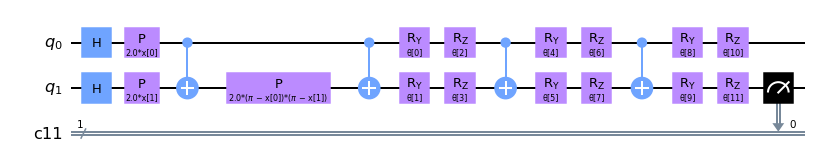

In [99]:
#Testing the QuantumCircuit class
test_circuit = QNN(Aer.get_backend('qasm_simulator'), 1000)
# simulator = qiskit.Aer.get_backend('qasm_simulator')

# circuit = QNN(4, "linear", simulator, 100,1,2)
# print("Expected state=", circuit.run([0.1,0.7,0.62,0]))
test_circuit._circuit.decompose().draw("mpl")

In [100]:
test_circuit._num_parameters,test_circuit._num_weights_two_local,test_circuit._num_weights_zz

(14, 12, 2)

In [103]:
test_circuit.run(np.random.randn(test_circuit._num_parameters))

array([0.071])

In [102]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift, nb_features=2, entanglement_type='linear',reps1=1,reps2=2):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QNN(backend, shots, nb_features=nb_features, 
                                   entanglement_type=entanglement_type,reps1=reps1,reps2=reps2)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [90]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
print(X_train.data[0])
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)
print(train_loader)

2.1%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




11.0%

100.0%
112.7%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  

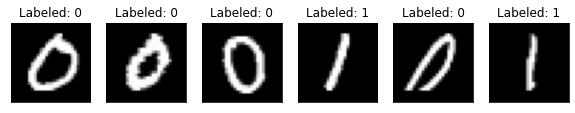

In [91]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [93]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
# print(X_test[0])
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [138]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 14) 
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)
    
class NetC(nn.Module):
    def __init__(self):
        super(NetC, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 14) 
#         self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
#         x = self.hybrid(x)
        return x#torch.cat((x, 1 - x), -1)

In [139]:
test2=Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
test1=NetC()

/tmp/ipykernel_6355/487597314.py:28: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit=self._fmap_zz + self._ansatz_tl


In [141]:
for batch_idx, (data, target) in enumerate(train_loader):
    datac=test1(data)
    dataqc=test2(datac)
    dataqc.backward()
#     loss = loss_func(output, target)
#     loss.backward()
    print(dataqc)
    break

/tmp/ipykernel_6355/4156652983.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


RuntimeError: Function HybridFunctionBackward returned an invalid gradient at index 0 - got [1, 1, 1] but expected shape compatible with [1, 14]

In [124]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_6355/487597314.py:28: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit=self._fmap_zz + self._ansatz_tl
/tmp/ipykernel_6355/4156652983.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


RuntimeError: Function HybridFunctionBackward returned an invalid gradient at index 0 - got [1, 1, 1] but expected shape compatible with [1, 14]

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1